#### Catastrophic forgetting
- It was first recognized by McCloskey and Cohen(1989). They found that, when training on new tasks or categories, a neural network tends to forget the information learned in the previous trained tasks. This usually means a new task
will likely **override the weights** that have been learned in the past.

-  Without fixing this problem, a single neural network will not be able to adapt itself to an Life-long scenario, because it forgets the existing information/knowledge when it learns new things.

- A concrete example of catastrophic forgetting is transfer learning. Fine-tuning is widely used to adapt the model for the source domain to the target domain. However, such an approach suffers from catastrophic forgetting because the adaptation to the target domain usually disrupts the weights learned for the source domain, resulting inferior inference in the source domain.

####  elastic weight consolidation (EWC)
- Kirkpatrick et al.[2017] proposed
a model called Elastic Weight Consolidation (EWC) that quantifies the importance of weights
to previous tasks, and selectively adjusts the plasticity of weights.

<img src=attachment:image.png width=350>
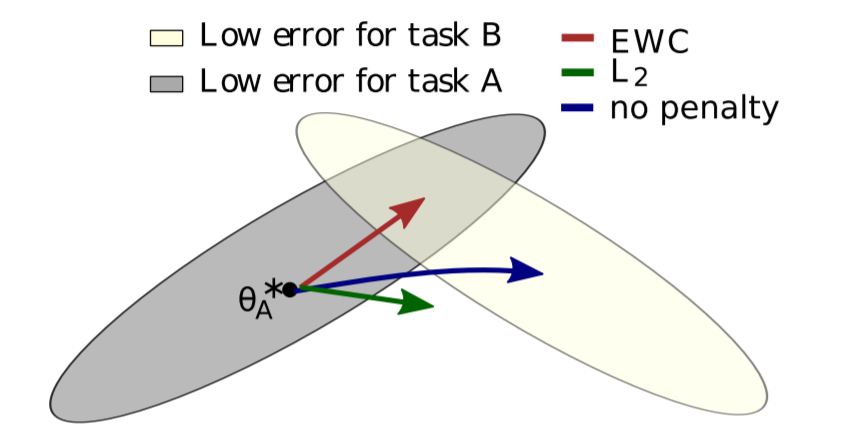

- EWC ensures task A is remembered whilst training on task B.
- After learning the first task, the parameters are at $\theta_A^*$. If we take gradient steps according to task B alone (blue arrow), we will minimize the loss of task B but destroy what we have learnt for task A. 

- To avoid forgetting the learned knowledge in task A, one simple trick is that we can minimize the distances between $\theta$ and $\theta_A^*$. Thus, the learning process becomes
$$\theta^* = \underset{\theta}{\operatorname{argmin}} \mathcal{L_{B}(\theta)} + \frac{1}{2}\alpha (\theta - \theta_\mathcal{A}^*)^2$$
where $\alpha$ is the scalar sets how important the old task is compared to the new one.

> It turns out that the l2 constraint is so strong that it could hamper the learning process of task B. Here, we have one more observation: In neural networks, we often over-parametrize the models. There might be some parameters that are less useful and others are more valuable. In the l2 constraint case, each parameter is treated equally. Here, we want to use the **diagonal components in Fisher Information Matrix** to identify which parameters are more important to task A and apply higher weights to them.
$$\theta^* = \underset{\theta}{\operatorname{argmin}} \mathcal{L_{B}(\theta)} + \frac{1}{2} \alpha I_{\theta^*_\mathcal{A}, i} (\theta_i - \theta^*_{\mathcal{A}, i})^2$$

where $I_i$ is the diagonal of the Fisher Information Matrix and 
$i$ is the index of each parameter

- EWC에서는 curvature가 큰 $\theta$일수록 조금만 움직여도 Task A의 성능이 떨어질 수 있으니 움직이지 않게 강하게 regularization.
- Natural Gradient에서는 curvature가 큰 $\theta$일수록 작은 step으로 update

- To compute $I_i$, we sample the data from task A once and calculate the empirical Fisher Information Matrix,
$$I_{\theta_\mathcal{A}^*} = \frac{1}{N}  \sum_{i=1}^{N} \nabla_\theta log \ p(x_{\mathcal{A}, i}|\theta_\mathcal{A}^*) \nabla_\theta log \ p(x_{\mathcal{A}, i}|\theta_\mathcal{A}^*)^T$$

#### Implementations 

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch import autograd
import numpy as np

from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms

import copy

In [2]:
device = torch.device("cuda:0")

In [3]:
mnist_train = datasets.MNIST("../data", train=True, download=True, transform=transforms.ToTensor())
mnist_test = datasets.MNIST("../data", train=False, download=True, transform=transforms.ToTensor())
mnist_train_loader = DataLoader(mnist_train, batch_size = 100, shuffle=True)
mnist_test_loader = DataLoader(mnist_test, batch_size = 100, shuffle=False)

In [4]:
fmnist_train = datasets.FashionMNIST("../data", train=True, download=True, transform=transforms.ToTensor())
fmnist_test = datasets.FashionMNIST("../data", train=False, download=True, transform=transforms.ToTensor())
fmnist_train_loader = DataLoader(fmnist_train, batch_size = 100, shuffle=True)
fmnist_test_loader = DataLoader(fmnist_test, batch_size = 100, shuffle=False)

In [5]:
class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        
        self.linear1 = nn.Linear(784,256)
        self.linear2 = nn.Linear(256,128)
        self.linear3 = nn.Linear(128,10)
        self.relu = F.relu
        self.bn1 = nn.BatchNorm1d(256)
        self.bn2 = nn.BatchNorm1d(128)
            
    def forward(self, x):
        x = self.relu(self.bn1(self.linear1(x)))
        x = self.relu(self.bn2(self.linear2(x)))        
        x = self.linear3(x)
        return x

In [6]:
model = Net().to(device)

In [7]:
def basic_training(net, data_loader):
    net.train()

    total_batch = len(data_loader)  # 60000/100= 600
    criterion = torch.nn.CrossEntropyLoss().to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=0.0001)
    
    for epoch in range(4):    
        avg_loss = 0
        for X_batch, Y_batch in data_loader:
            X_batch = torch.reshape(X_batch, [-1, 784]).to(device)
            Y_batch = Y_batch.to(device)

            pred = net(X_batch)
            loss = criterion(pred, Y_batch)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            avg_loss += loss
        avg_loss /= total_batch
        print('epoch:', epoch, 'loss: ', avg_loss.item())

In [8]:
basic_training(model, mnist_train_loader)

epoch: 0 loss:  0.9467146992683411
epoch: 1 loss:  0.3141005337238312
epoch: 2 loss:  0.17265476286411285
epoch: 3 loss:  0.11330603808164597


In [9]:
def mnist_test_accuracy(model):
    correct = 0
    total = 0
    with torch.no_grad():
        model.eval()
        for data in mnist_test_loader:
            images, labels = data
            output = model(images.view(-1,784).to(device))
            _, predicted = torch.max(output, dim=1)        
            total += labels.size(0)
            correct += (predicted ==labels.to(device)).sum().item()

    return correct / total

In [10]:
def fmnist_test_accuracy(model):
    correct = 0
    total = 0
    with torch.no_grad():
        model.eval()
        for data in fmnist_test_loader:
            images, labels = data
            output = model(images.view(-1,784).to(device))
            _, predicted = torch.max(output, dim=1)        
            total += labels.size(0)
            correct += (predicted ==labels.to(device)).sum().item()

    return correct / total

In [14]:
mnist_test_accuracy(model)

0.9751

In [11]:
fmnist_test_accuracy(model)

0.0754

In [12]:
for param_name, param in model.named_parameters():
    print(param_name)

linear1.weight
linear1.bias
linear2.weight
linear2.bias
linear3.weight
linear3.bias
bn1.weight
bn1.bias
bn2.weight
bn2.bias


####  Fine-tuning: Adapt the pre-trained MNIST model to the f-MNIST

In [13]:
class EWC:

    def __init__(self, model, weight=1000):
        self.model = model
        self.weight = weight
        self.crit = torch.nn.CrossEntropyLoss().to(device)
        self.optimizer = optim.Adam(self.model.parameters(), lr=0.0001)
    
    def _update_mean_params(self):   #mean은 현재값 그대로 buffer에 옮겨 놓기
        for param_name, param in self.model.named_parameters():
            _buff_param_name = param_name.replace('.', '__')
            self.model.register_buffer(_buff_param_name+'_estimated_mean', param.data.clone())

    def _update_fisher_params(self, current_dl):
        log_liklihoods = []
        for i, (img, target) in enumerate(current_dl):
            if i>1:
                break
            img = torch.reshape(img, [-1, 784]).to(device)
            target = target.to(device)
            
            # test 
            out = self.model(img)
            
            # test
            
            output = F.log_softmax(self.model(img), dim=1)
            log_liklihoods.append(output[:, target])
        log_likelihood = torch.cat(log_liklihoods).mean()
        grad_log_liklihood = autograd.grad(log_likelihood, self.model.parameters())
        _buff_param_names = [param[0].replace('.', '__') for param in self.model.named_parameters()]
        for _buff_param_name, grad_log in zip(_buff_param_names, grad_log_liklihood):
            self.model.register_buffer(_buff_param_name+'_estimated_fisher', grad_log.data.clone() ** 2)
#         return out, target, output, log_liklihoods, grad_log_liklihood, self.model
    
    def register_ewc_params(self, current_dataloader):
        self._update_fisher_params(current_dataloader)
        self._update_mean_params()

    def _compute_consolidation_loss(self, weight):
        try:
            losses = []
            for param_name, param in self.model.named_parameters():
                _buff_param_name = param_name.replace('.', '__')
                estimated_mean = getattr(self.model, '{}_estimated_mean'.format(_buff_param_name))
                estimated_fisher = getattr(self.model, '{}_estimated_fisher'.format(_buff_param_name))
                losses.append((estimated_fisher * (param - estimated_mean) ** 2).sum())
            return (weight / 2) * sum(losses)
        except AttributeError:
            return 0

    def train(self, img, target):
        output = self.model(img)
        loss = self._compute_consolidation_loss(self.weight) + self.crit(output, target)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        return self._compute_consolidation_loss(self.weight).cpu().detach(), self.crit(output, target).cpu().detach()

In [15]:
ewc = EWC(copy.deepcopy(model), weight=1000)

In [16]:
ewc.register_ewc_params(mnist_train_loader)

In [17]:
ewc.model.linear1__weight_estimated_fisher.shape

torch.Size([256, 784])

In [18]:
print(ewc.model.linear1__weight_estimated_mean.shape)
print(torch.max(ewc.model.linear1__bias_estimated_fisher))
print(torch.min(ewc.model.linear1__bias_estimated_fisher))

torch.Size([256, 784])
tensor(0.0646, device='cuda:0')
tensor(1.0764e-08, device='cuda:0')


In [19]:
for epoch in range(4):
    for img, target in fmnist_train_loader:
        img = torch.reshape(img, [-1, 784]).to(device)
        target = target.to(device)

        consolidation_loss, new_task_loss= ewc.train(img, target)
    print('epoch:{}, consolidation_loss:{:.3f}, new_task_loss:{:.3f}'\
          .format(epoch, consolidation_loss, new_task_loss))

epoch:0, consolidation_loss:0.041, new_task_loss:0.476
epoch:1, consolidation_loss:0.034, new_task_loss:0.446
epoch:2, consolidation_loss:0.031, new_task_loss:0.226
epoch:3, consolidation_loss:0.030, new_task_loss:0.389


In [20]:
mnist_test_accuracy(ewc.model)

0.8589

In [21]:
fmnist_test_accuracy(ewc.model)

0.857

- Default fine-tuning method

In [22]:
model_base = copy.deepcopy(model)
basic_training(model_base, fmnist_train_loader)

epoch: 0 loss:  0.6465213894844055
epoch: 1 loss:  0.3848293423652649
epoch: 2 loss:  0.3358354866504669
epoch: 3 loss:  0.30788660049438477


In [23]:
mnist_test_accuracy(model_base)

0.2812

In [24]:
fmnist_test_accuracy(model_base)

0.8619

If we increase the consolidation weight to 10,000. (put more importance on previous task)

In [25]:
ewc = EWC(copy.deepcopy(model), weight=10000)

In [26]:
ewc.register_ewc_params(mnist_train_loader)

for epoch in range(4):
    for img, target in fmnist_train_loader:
        img = torch.reshape(img, [-1, 784]).to(device)
        target = target.to(device)

        consolidation_loss, new_task_loss= ewc.train(img, target)
    print('epoch:{}, consolidation_loss:{:.3f}, new_task_loss:{:.3f}'\
          .format(epoch, consolidation_loss, new_task_loss))

epoch:0, consolidation_loss:0.059, new_task_loss:0.409
epoch:1, consolidation_loss:0.047, new_task_loss:0.465
epoch:2, consolidation_loss:0.041, new_task_loss:0.346
epoch:3, consolidation_loss:0.039, new_task_loss:0.294


In [27]:
mnist_test_accuracy(ewc.model)

0.9391

In [28]:
fmnist_test_accuracy(ewc.model)

0.8471

- Increase weight to 100,000

In [29]:
ewc = EWC(copy.deepcopy(model), weight=100000)

In [30]:
ewc.register_ewc_params(mnist_train_loader)

for epoch in range(4):
    for img, target in fmnist_train_loader:
        img = torch.reshape(img, [-1, 784]).to(device)
        target = target.to(device)

        consolidation_loss, new_task_loss= ewc.train(img, target)
    print('epoch:{}, consolidation_loss:{:.3f}, new_task_loss:{:.3f}'\
          .format(epoch, consolidation_loss, new_task_loss))

epoch:0, consolidation_loss:0.074, new_task_loss:0.535
epoch:1, consolidation_loss:0.052, new_task_loss:0.376
epoch:2, consolidation_loss:0.047, new_task_loss:0.593
epoch:3, consolidation_loss:0.047, new_task_loss:0.427


In [31]:
mnist_test_accuracy(ewc.model)

0.9657

In [32]:
fmnist_test_accuracy(ewc.model)

0.8389